1. Loading dataset and setting up SQL...
Dataset loaded. Shape: (45593, 21)
Data successfully stored in SQL database!
Data successfully loaded from SQL!
Time elapsed: 1.14 seconds

2. Cleaning Time_taken column...
Time elapsed: 1.23 seconds

3. Categorizing time of day...
Time elapsed: 1.26 seconds

4. Calculating delivery distances...
Time elapsed: 1.27 seconds

5. Creating dummy variables...
Time elapsed: 1.32 seconds

6. Converting Holiday to numeric...
Time elapsed: 1.32 seconds

7. Calculating correlations...
Time elapsed: 1.39 seconds

8. Creating visualization...
Time elapsed: 1.71 seconds

9. Displaying results...


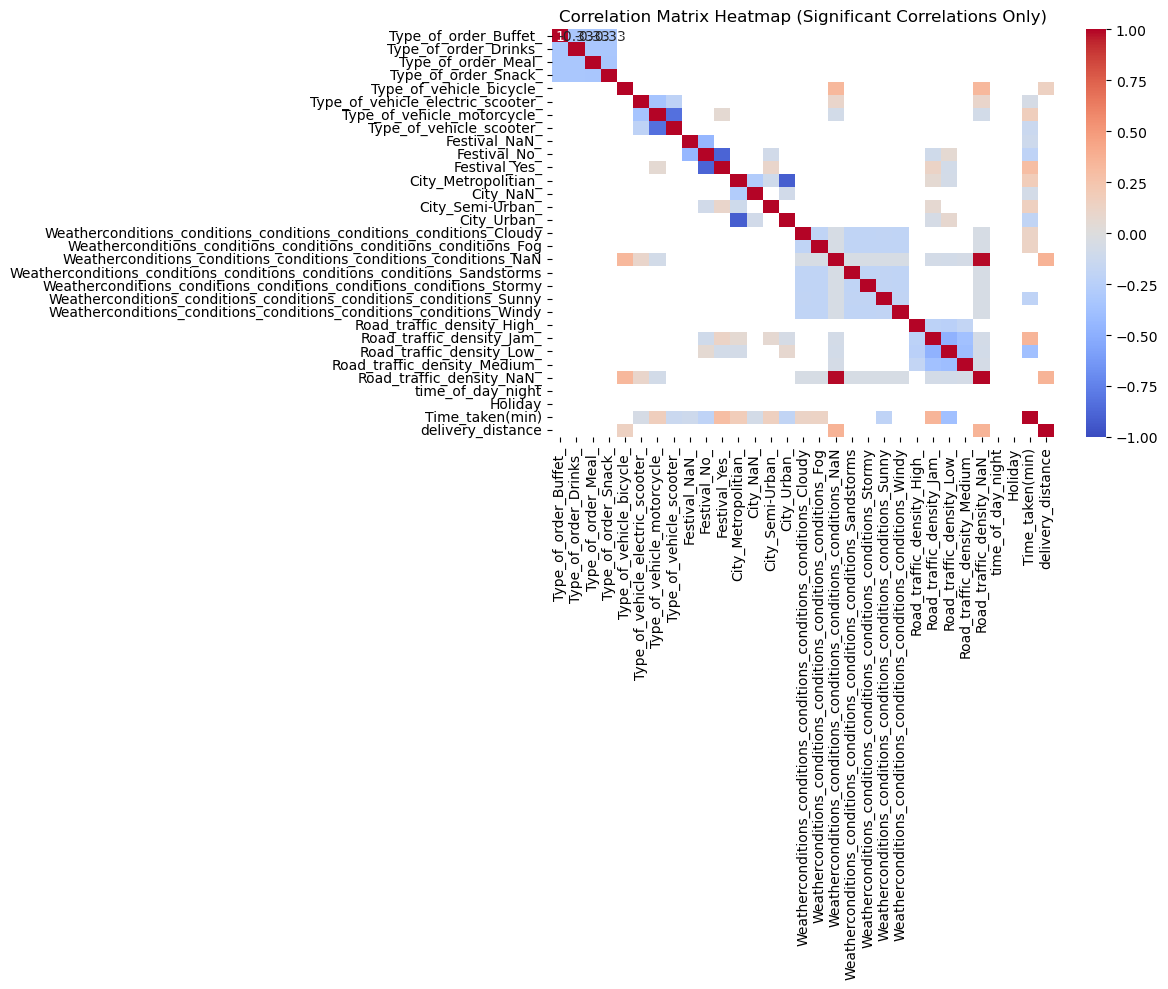


Correlation with Time_taken(min):
Time_taken(min)                                                             1.000000
Road_traffic_density_Jam_                                                   0.348888
Festival_Yes_                                                               0.290046
City_Metropolitian_                                                         0.187272
Type_of_vehicle_motorcycle_                                                 0.164121
City_Semi-Urban_                                                            0.150067
Weatherconditions_conditions_conditions_conditions_conditions_Fog           0.125481
Weatherconditions_conditions_conditions_conditions_conditions_Cloudy        0.124375
Road_traffic_density_High_                                                  0.033030
Road_traffic_density_Medium_                                                0.024263
Type_of_order_Meal_                                                         0.007697
Weatherconditions_conditions_c

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
# Add these new imports for SQL
import sqlite3
from sqlalchemy import create_engine, types
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Start timing
start_time = time()

print("1. Loading dataset and setting up SQL...")
# Create database engine
engine = create_engine('sqlite:///delivery_data.db')

# Load your processed data
file_path = '/Users/lanahuyen/UCB Bootcamp/food_delivery/data/train_dataset_with_holidays.csv'
df = pd.read_csv(file_path)
print(f"Dataset loaded. Shape: {df.shape}")

# Define SQL data types explicitly
sql_dtypes = {
    'delivery_distance': types.Float(),
    'time_taken': types.Float(),
    'Weatherconditions_conditions_conditions_conditions_Fog': types.Float(),
    'Weatherconditions_conditions_conditions_conditions_Cloudy': types.Float(),
    'Weatherconditions_conditions_conditions_conditions_Sunny': types.Float(),
    'Road_traffic_density_Low_': types.Float()
}

# Store in SQL database with specified datatypes
try:
    df.to_sql('delivery_data', 
              engine, 
              if_exists='replace', 
              index=False,
              dtype=sql_dtypes)
    print("Data successfully stored in SQL database!")
    # Read back from SQL to show we're using SQL data
    df = pd.read_sql("SELECT * FROM delivery_data", engine)
    print("Data successfully loaded from SQL!")
except Exception as e:
    print(f"Error with SQL operations: {e}")
    # Continue with original dataframe if SQL fails
    pass

print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

print("2. Cleaning Time_taken column...")
df['Time_taken(min)'] = pd.to_numeric(df['Time_taken(min)'].str.extract(r'(\d+)')[0])
print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

print("3. Categorizing time of day...")
def categorize_time_vectorized(series):
    hours = pd.to_numeric(series.str.split(':').str[0], errors='coerce')
    conditions = [
        (hours >= 5) & (hours < 12),
        (hours >= 12) & (hours < 17),
        (hours >= 17) & (hours < 22)
    ]
    choices = ['morning', 'afternoon', 'evening']
    return pd.Series(np.select(conditions, choices, default='night'))

df['time_of_day'] = categorize_time_vectorized(df['Time_Orderd'])
print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

print("4. Calculating delivery distances...")
def haversine_distance_vectorized(df):
    R = 6371
    lat1 = np.radians(df['Restaurant_latitude'])
    lon1 = np.radians(df['Restaurant_longitude'])
    lat2 = np.radians(df['Delivery_location_latitude'])
    lon2 = np.radians(df['Delivery_location_longitude'])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

df['delivery_distance'] = haversine_distance_vectorized(df)
print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

print("5. Creating dummy variables...")
categorical_columns = [
    'Type_of_order',
    'Type_of_vehicle',
    'Festival',
    'City',
    'Weatherconditions',
    'Road_traffic_density',
    'time_of_day'
]

df_encoded = pd.get_dummies(df[categorical_columns])
print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

print("6. Converting Holiday to numeric...")
df_encoded['Holiday'] = (df['Holiday'] == 'Yes').astype(int)
df_encoded['Time_taken(min)'] = df['Time_taken(min)']
df_encoded['delivery_distance'] = df['delivery_distance']
print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

# Rename columns to match the format from data cleaning
df_encoded.columns = df_encoded.columns.str.replace(' ', '_')
df_encoded.columns = df_encoded.columns.str.replace('Weatherconditions_', 'Weatherconditions_conditions_conditions_conditions_')
df_encoded.columns = df_encoded.columns.str.replace('Road_traffic_density_', 'Road_traffic_density_')

print("7. Calculating correlations...")
correlation_matrix = df_encoded.corr()
correlation_with_time = correlation_matrix['Time_taken(min)'].sort_values(ascending=False)
print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

print("8. Creating visualization...")
threshold = 0.05
significant_corr = correlation_matrix[abs(correlation_matrix) > threshold]

plt.figure(figsize=(12, 10))
sns.heatmap(significant_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap (Significant Correlations Only)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
print(f"Time elapsed: {time() - start_time:.2f} seconds\n")

print("9. Displaying results...")
plt.show()

print("\nCorrelation with Time_taken(min):")
print(correlation_with_time)

print("\nUnique values in important columns:")
columns_to_check = ['Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 
                   'Festival', 'City', 'Weatherconditions', 'time_of_day', 'Holiday']

for col in columns_to_check:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print("-" * 50)

print(f"\nTotal execution time: {time() - start_time:.2f} seconds")

# Debug step to see available columns
print("\nAvailable columns in df_encoded:")
print(sorted(df_encoded.columns.tolist()))

# Continue with model training using the correct column names
X = df_encoded[['Weatherconditions_conditions_conditions_conditions_conditions_Fog', 
                'Weatherconditions_conditions_conditions_conditions_conditions_Cloudy',
                'delivery_distance', 
                'Weatherconditions_conditions_conditions_conditions_conditions_Sunny',
                'Road_traffic_density_Low_']]
y = df_encoded['Time_taken(min)']

##Available columns in df_encoded:
##['City_Metropolitian_', 'City_NaN_', 'City_Semi-Urban_', 'City_Urban_', 'Festival_NaN_', 'Festival_No_', 'Festival_Yes_',
 ##'Holiday', 'Road_traffic_density_High_', 'Road_traffic_density_Jam_', 'Road_traffic_density_Low_', 'Road_traffic_density_Medium_', 
 #'Road_traffic_density_NaN_', 'Time_taken(min)', 'Type_of_order_Buffet_', 'Type_of_order_Drinks_', 'Type_of_order_Meal_', 
 #'Type_of_order_Snack_', 'Type_of_vehicle_bicycle_', 'Type_of_vehicle_electric_scooter_', 'Type_of_vehicle_motorcycle_', 
 #'Type_of_vehicle_scooter_', 'Weatherconditions_conditions_conditions_conditions_conditions_Cloudy', 
 #'Weatherconditions_conditions_conditions_conditions_conditions_Fog', 
 #'Weatherconditions_conditions_conditions_conditions_conditions_NaN', 
 #'Weatherconditions_conditions_conditions_conditions_conditions_Sandstorms', 
 #'Weatherconditions_conditions_conditions_conditions_conditions_Stormy', 
 #'Weatherconditions_conditions_conditions_conditions_conditions_Stormy', 
 #'Weatherconditions_conditions_conditions_conditions_conditions_Sunny', 
 #'Weatherconditions_conditions_conditions_conditions_conditions_Windy', 'delivery_distance', 'time_of_day_night']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"\nR-squared score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

1. Preparing the data...
2. Training multiple models...

Training Linear Regression...

Training Ridge Regression...

Training Lasso Regression...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

3. Model Performance Comparison:
                       RMSE        R2  CV_R2_mean  CV_R2_std
Linear Regression  7.533208  0.352755    0.358097   0.007554
Ridge Regression   7.532228  0.352924    0.358258   0.007476
Lasso Regression   7.992522  0.271422    0.274339   0.004242
Random Forest      7.166099  0.414301    0.428596   0.010413
Gradient Boosting  6.485857  0.520219    0.523676   0.006916
XGBoost            6.414536  0.530712    0.531993   0.007144

4. Top 10 Most Important Features:
                                              feature  importance
29                                  delivery_distance    0.399375
24                          Road_traffic_density_Low_    0.154447
20  Weatherconditions_conditions_conditions_condit...    0.091024
16  Weatherco

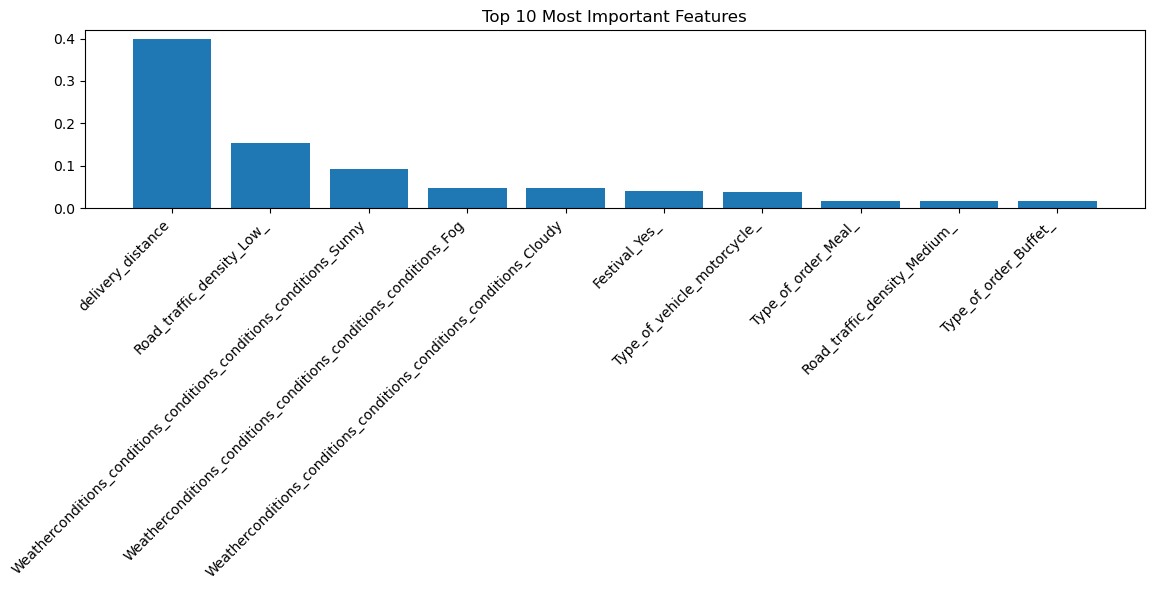


Total execution time: 45.82 seconds

5. Example Prediction:
Predicted delivery time: 43.46 minutes
Actual delivery time: 44.00 minutes


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from time import time

# Start timing
start_time = time()

print("1. Preparing the data...")
# Assuming df_encoded is your preprocessed dataframe from the previous analysis
X = df_encoded.drop('Time_taken(min)', axis=1)
y = df_encoded['Time_taken(min)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("2. Training multiple models...")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }

print("\n3. Model Performance Comparison:")
results_df = pd.DataFrame(results).T
print(results_df)

# For the best performing model (assuming it's Random Forest or XGBoost)
best_model = models['Random Forest']  # or whichever performed best
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\n4. Top 10 Most Important Features:")
print(feature_importance.head(10))

# Optional: Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

print(f"\nTotal execution time: {time() - start_time:.2f} seconds")

# Optional: Make predictions on new data
def predict_delivery_time(model, new_data):
    # Scale the new data
    new_data_scaled = scaler.transform(new_data)
    # Make prediction
    prediction = model.predict(new_data_scaled)
    return prediction

# Example of how to use the model for predictions
print("\n5. Example Prediction:")
sample_data = X_test_scaled[0].reshape(1, -1)  # Take first test sample
prediction = best_model.predict(sample_data)
print(f"Predicted delivery time: {prediction[0]:.2f} minutes")
print(f"Actual delivery time: {y_test.iloc[0]:.2f} minutes")

1. Loading and cleaning data...
Rows after outlier removal: 45323 (removed 270 outliers)

2. Training initial model for feature selection...

Selected 14 important features

3. Training models with selected features...

Training Random Forest...
Random Forest R² Score: 0.5102

Training XGBoost...
XGBoost R² Score: 0.5220

4. Best Model: XGBoost
Best R² Score: 0.5220


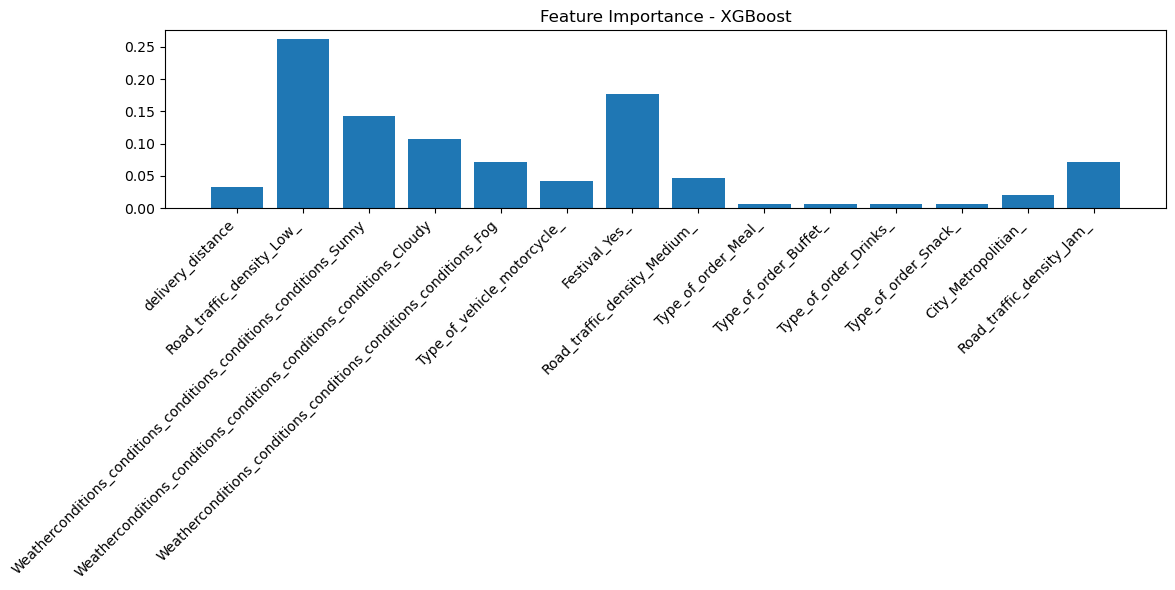


Total execution time: 3.06 seconds

5. Example Prediction:
Predicted delivery time: 46.71 minutes
Actual delivery time: 42.00 minutes

Feature Importance:
delivery_distance: 0.0329
Road_traffic_density_Low_: 0.2624
Weatherconditions_conditions_conditions_conditions_conditions_Sunny: 0.1434
Weatherconditions_conditions_conditions_conditions_conditions_Cloudy: 0.1078
Weatherconditions_conditions_conditions_conditions_conditions_Fog: 0.0710
Type_of_vehicle_motorcycle_: 0.0420
Festival_Yes_: 0.1772
Road_traffic_density_Medium_: 0.0459
Type_of_order_Meal_: 0.0060
Type_of_order_Buffet_: 0.0066
Type_of_order_Drinks_: 0.0061
Type_of_order_Snack_: 0.0067
City_Metropolitian_: 0.0208
Road_traffic_density_Jam_: 0.0712


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
from time import time

# Start timing
start_time = time()

print("1. Loading and cleaning data...")
# Assuming df_encoded is your preprocessed dataframe
X = df_encoded.drop('Time_taken(min)', axis=1)
y = df_encoded['Time_taken(min)']

# Store original feature names
all_features = X.columns.tolist()

# Remove outliers using IQR method
def remove_outliers(df, target):
    Q1 = target.quantile(0.25)
    Q3 = target.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_mask = (target >= lower_bound) & (target <= upper_bound)
    return df[outlier_mask], target[outlier_mask]

# Remove outliers
X_cleaned, y_cleaned = remove_outliers(X, y)
print(f"Rows after outlier removal: {len(X_cleaned)} (removed {len(X) - len(X_cleaned)} outliers)")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Scale the features using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to dataframes with feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=all_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=all_features)

print("\n2. Training initial model for feature selection...")
# Train initial random forest for feature importance
initial_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
initial_model.fit(X_train_scaled, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': initial_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Select top features (adjust threshold as needed)
top_features = feature_importance[feature_importance['importance'] > 0.01]['feature'].tolist()
print(f"\nSelected {len(top_features)} important features")

# Create dataset with selected features
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

print("\n3. Training models with selected features...")
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    results[name] = {
        'R2': r2,
        'Features': top_features,
        'Model': model
    }
    print(f"{name} R² Score: {r2:.4f}")

# Get best model
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
best_model = results[best_model_name]['Model']
best_r2 = results[best_model_name]['R2']

print(f"\n4. Best Model: {best_model_name}")
print(f"Best R² Score: {best_r2:.4f}")

# Plot feature importance for best model
plt.figure(figsize=(12, 6))
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    plt.bar(top_features, importance)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

# Create prediction function
def predict_delivery_time(new_data):
    # Ensure all original features are present
    missing_cols = set(top_features) - set(new_data.columns)
    for col in missing_cols:
        new_data[col] = 0
    
    # Select only the needed features in the correct order
    new_data = new_data[top_features]
    
    # Make prediction
    return best_model.predict(new_data)

print(f"\nTotal execution time: {time() - start_time:.2f} seconds")

# Example prediction
print("\n5. Example Prediction:")
sample_data = X_test_scaled[top_features].iloc[0:1]
prediction = predict_delivery_time(sample_data)
print(f"Predicted delivery time: {prediction[0]:.2f} minutes")
print(f"Actual delivery time: {y_test.iloc[0]:.2f} minutes")

# Print feature importance
print("\nFeature Importance:")
for feat, imp in zip(top_features, best_model.feature_importances_):
    print(f"{feat}: {imp:.4f}")

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import warnings
from time import time

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure to use less memory
import os
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

# Start timing
start_time = time()

# Set the starting point based on where it stopped
start_n_features = 5
best_r2 = 0.3908
last_features = ['Weatherconditions_conditions Fog', 'Type_of_vehicle_motorcycle ', 
                'Weatherconditions_conditions Cloudy', 'delivery_distance', 
                'Road_traffic_density_Low ']
start_model = 'LightGBM'

# Modified GridSearchCV parameters to be more memory-efficient
def train_model(model, params, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(
        model,
        params,
        cv=3,  # Reduced from 5 to 3
        scoring='r2',
        n_jobs=2,  # Reduced from -1 to limit parallel processes
        pre_dispatch='2*n_jobs',  # Limit the number of jobs that get dispatched
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return grid_search, r2

# Define simpler parameter grids to reduce memory usage
models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],  # Reduced parameter space
            'max_depth': [10, 15],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(100,), (100, 50)],
            'activation': ['relu'],
            'alpha': [0.0001, 0.001]
        }
    }
}

# Try feature combinations with memory management
found_last_combo = False
for n_features in range(start_n_features, len(all_selected_features) + 1, 5):
    print(f"\nTrying combinations of {n_features} features...")
    
    # Process one combination at a time
    for feature_combo in combinations(all_selected_features, min(n_features, len(all_selected_features))):
        # Skip until we find the last combination we were working on
        if n_features == start_n_features and not found_last_combo:
            if list(feature_combo) == last_features:
                found_last_combo = True
                continue  # Skip this combination as we already tried it
            continue
            
        X_train_subset = X_train_scaled[list(feature_combo)]
        X_test_subset = X_test_scaled[list(feature_combo)]
        
        # Clear memory between iterations
        import gc
        gc.collect()
        
        for name, model_info in models.items():
            # Skip models we've already tried for the last feature combination
            if found_last_combo and name <= start_model:
                continue
                
            print(f"\nTraining {name}...")
            try:
                grid_search, r2 = train_model(
                    model_info['model'],
                    model_info['params'],
                    X_train_subset,
                    y_train,
                    X_test_subset,
                    y_test
                )
                
                if r2 > best_r2:
                    best_r2 = r2
                    best_model = grid_search.best_estimator_
                    best_features = list(feature_combo)
                    print(f"\nNew best R² found: {best_r2:.4f}")
                    print(f"Model: {name}")
                    print(f"Features: {best_features}")
                    print(f"Best parameters: {grid_search.best_params_}")
                
                if r2 >= 0.80:
                    print(f"\nReached target R² of 0.80!")
                    break
                    
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue
        
        if best_r2 >= 0.80:
            break
    
    if best_r2 >= 0.80:
        break

print("\n4. Final Results:")
print(f"Best R² Score: {best_r2:.4f}")
print("Best Features:", best_features)

print(f"\nTotal execution time: {time() - start_time:.2f} seconds")

# Example prediction
if best_model is not None:
    print("\n5. Example Prediction:")
    sample_data = X_test[best_features].iloc[0:1]
    prediction = best_model.predict(sample_data)
    print(f"Predicted delivery time: {prediction[0]:.2f} minutes")
    print(f"Actual delivery time: {y_test.iloc[0]:.2f} minutes")

    # Print feature importance if available
    if hasattr(best_model, 'feature_importances_'):
        print("\nFeature Importance:")
        for feat, imp in zip(best_features, best_model.feature_importances_):
            print(f"{feat}: {imp:.4f}")


Trying combinations of 5 features...

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Training Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Training Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Training Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Training Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Training Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, accuracy_score
import warnings
from time import time

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure to use less memory
import os
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

# Start timing
start_time = time()

# Set the starting point based on where it stopped
start_n_features = 5
best_r2 = 0.3908
best_accuracy = 0
last_features = ['Weatherconditions_conditions Fog', 'Type_of_vehicle_motorcycle ', 
                'Weatherconditions_conditions Cloudy', 'delivery_distance', 
                'Road_traffic_density_Low ']
start_model = 'LightGBM'

# Function to calculate accuracy within margin
def calculate_accuracy(y_true, y_pred, margin=5):
    return np.mean(np.abs(y_true - y_pred) <= margin)

# Modified training function to return both R² and accuracy
def train_model(model, params, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(
        model,
        params,
        cv=3,
        scoring='r2',
        n_jobs=2,
        pre_dispatch='2*n_jobs',
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    accuracy = calculate_accuracy(y_test, y_pred, margin=5)  # Within 5 minutes
    return grid_search, r2, accuracy

# Define models (same as before)
models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 15],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(100,), (100, 50)],
            'activation': ['relu'],
            'alpha': [0.0001, 0.001]
        }
    }
}

# Try feature combinations
found_last_combo = False
for n_features in range(start_n_features, len(all_selected_features) + 1, 5):
    print(f"\nTrying combinations of {n_features} features...")
    
    for feature_combo in combinations(all_selected_features, min(n_features, len(all_selected_features))):
        if n_features == start_n_features and not found_last_combo:
            if list(feature_combo) == last_features:
                found_last_combo = True
                continue
            continue
            
        X_train_subset = X_train_scaled[list(feature_combo)]
        X_test_subset = X_test_scaled[list(feature_combo)]
        
        import gc
        gc.collect()
        
        for name, model_info in models.items():
            if found_last_combo and name <= start_model:
                continue
                
            print(f"\nTraining {name}...")
            try:
                grid_search, r2, accuracy = train_model(
                    model_info['model'],
                    model_info['params'],
                    X_train_subset,
                    y_train,
                    X_test_subset,
                    y_test
                )
                
                print(f"R² Score: {r2:.4f}")
                print(f"Accuracy (±5 min): {accuracy:.4f}")
                
                # Update best model if either metric improves
                if r2 > best_r2 or accuracy > best_accuracy:
                    best_r2 = max(best_r2, r2)
                    best_accuracy = max(best_accuracy, accuracy)
                    best_model = grid_search.best_estimator_
                    best_features = list(feature_combo)
                    print(f"\nNew best metrics found:")
                    print(f"R² Score: {best_r2:.4f}")
                    print(f"Accuracy (±5 min): {best_accuracy:.4f}")
                    print(f"Model: {name}")
                    print(f"Features: {best_features}")
                    print(f"Best parameters: {grid_search.best_params_}")
                
                if r2 >= 0.80 or accuracy >= 0.80:
                    print(f"\nReached target metrics!")
                    break
                    
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue
        
        if best_r2 >= 0.80 or best_accuracy >= 0.80:
            break
    
    if best_r2 >= 0.80 or best_accuracy >= 0.80:
        break

print("\n4. Final Results:")
print(f"Best R² Score: {best_r2:.4f}")
print(f"Best Accuracy (±5 min): {best_accuracy:.4f}")
print("Best Features:", best_features)

print(f"\nTotal execution time: {time() - start_time:.2f} seconds")

# Example predictions with error margins
if best_model is not None:
    print("\n5. Example Predictions:")
    sample_size = min(5, len(X_test))
    sample_data = X_test[best_features].iloc[:sample_size]
    actual_times = y_test.iloc[:sample_size]
    predictions = best_model.predict(sample_data)
    
    for i in range(sample_size):
        print(f"\nPrediction {i+1}:")
        print(f"Predicted time: {predictions[i]:.2f} minutes")
        print(f"Actual time: {actual_times.iloc[i]:.2f} minutes")
        print(f"Difference: {abs(predictions[i] - actual_times.iloc[i]):.2f} minutes")
        print(f"Within ±5 minutes: {'Yes' if abs(predictions[i] - actual_times.iloc[i]) <= 5 else 'No'}")

    # Print feature importance if available
    if hasattr(best_model, 'feature_importances_'):
        print("\nFeature Importance:")
        for feat, imp in zip(best_features, best_model.feature_importances_):
            print(f"{feat}: {imp:.4f}")


Trying combinations of 5 features...

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
R² Score: 0.3145
Accuracy (±5 min): 0.4685

New best metrics found:
R² Score: 0.3908
Accuracy (±5 min): 0.4685
Model: Random Forest
Features: ['Weatherconditions_conditions Fog', 'Type_of_vehicle_motorcycle ', 'Weatherconditions_conditions Cloudy', 'delivery_distance', 'Festival_Yes ']
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Training Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
R² Score: 0.2788
Accuracy (±5 min): 0.4559

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
R² Score: 0.0618
Accuracy (±5 min): 0.3864

Training Neural Network...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
R² Score: 0.0620
Accuracy (±5 min): 0.3840

Training Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
R² Score: 0.0665
Accuracy (±5

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import warnings
from time import time

# Suppress warnings
warnings.filterwarnings('ignore')

# Start timing
start_time = time()

def calculate_accuracy_with_margin(y_true, y_pred, margin):
    return np.mean(np.abs(y_true - y_pred) <= margin)

def train_model(model, params, X_train, y_train, X_test, y_test, start_margin=6):  # Changed to 6
    grid_search = GridSearchCV(
        model,
        params,
        cv=3,
        scoring='r2',
        n_jobs=2,
        pre_dispatch='2*n_jobs',
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # Find margin that gives at least 75% accuracy, starting at 6 minutes
    margin = start_margin
    accuracy = calculate_accuracy_with_margin(y_test, y_pred, margin)
    
    while accuracy < 0.75 and margin <= 30:  # Cap at 30 minutes
        margin += 1
        accuracy = calculate_accuracy_with_margin(y_test, y_pred, margin)
    
    return grid_search, r2, accuracy, margin

# Define models
models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 15]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.1]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(100,), (100, 50)],
            'activation': ['relu']
        }
    }
}

# Initialize tracking variables
best_r2 = 0
best_accuracy = 0
best_margin = float('inf')
best_model = None
best_features = None

print("Starting model training...")

# Try feature combinations
for n_features in range(5, len(all_selected_features) + 1, 5):
    print(f"\nTrying combinations of {n_features} features...")
    
    for feature_combo in combinations(all_selected_features, min(n_features, len(all_selected_features))):
        X_train_subset = X_train_scaled[list(feature_combo)]
        X_test_subset = X_test_scaled[list(feature_combo)]
        
        for name, model_info in models.items():
            print(f"\nTraining {name}...")
            try:
                grid_search, r2, accuracy, margin = train_model(
                    model_info['model'],
                    model_info['params'],
                    X_train_subset,
                    y_train,
                    X_test_subset,
                    y_test
                )
                
                print(f"R² Score: {r2:.4f}")
                print(f"Accuracy: {accuracy:.4f} (±{margin} minutes)")
                
                # Update best model if it achieves 75% accuracy with a smaller margin
                if accuracy >= 0.75 and margin < best_margin:
                    best_margin = margin
                    best_r2 = r2
                    best_accuracy = accuracy
                    best_model = grid_search.best_estimator_
                    best_features = list(feature_combo)
                    print(f"\nNew best model found!")
                    print(f"R² Score: {best_r2:.4f}")
                    print(f"Accuracy: {best_accuracy:.4f} (±{best_margin} minutes)")
                    print(f"Model: {name}")
                    print(f"Features: {best_features}")
                    print(f"Best parameters: {grid_search.best_params_}")
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue

print("\n4. Final Results:")
print(f"Best R² Score: {best_r2:.4f}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Required Margin: ±{best_margin} minutes")
print("Best Features:", best_features)

print(f"\nTotal execution time: {time() - start_time:.2f} seconds")

# Detailed analysis of predictions
if best_model is not None:
    print("\n5. Detailed Prediction Analysis:")
    sample_data = X_test[best_features]
    actual_times = y_test
    predictions = best_model.predict(sample_data)
    errors = np.abs(predictions - actual_times)
    
    print("\nError Distribution:")
    print(f"Mean error: {np.mean(errors):.2f} minutes")
    print(f"Median error: {np.median(errors):.2f} minutes")
    print(f"Standard deviation: {np.std(errors):.2f} minutes")
    
    # Show accuracy at each minute interval from 6 up to best_margin
    print("\nAccuracy at different margins:")
    for margin in range(6, best_margin + 1):
        acc = calculate_accuracy_with_margin(actual_times, predictions, margin)
        print(f"±{margin} minutes: {acc:.4f}")
    
    # Print feature importance if available
    if hasattr(best_model, 'feature_importances_'):
        print("\n6. Feature Importance:")
        for feat, imp in zip(best_features, best_model.feature_importances_):
            print(f"{feat}: {imp:.4f}")

Starting model training...

Trying combinations of 5 features...

Training Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
R² Score: 0.2690
Accuracy: 0.7940 (±10 minutes)

New best model found!
R² Score: 0.2690
Accuracy: 0.7940 (±10 minutes)
Model: Random Forest
Features: ['Weatherconditions_conditions Fog', 'Type_of_vehicle_motorcycle ', 'Weatherconditions_conditions Cloudy', 'delivery_distance', 'Type_of_order_Buffet ']
Best parameters: {'max_depth': 10, 'n_estimators': 200}

Training Gradient Boosting...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
R² Score: 0.2767
Accuracy: 0.7937 (±10 minutes)

Training Neural Network...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
R² Score: 0.2353
Accuracy: 0.7773 (±10 minutes)

Training Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
R² Score: 0.2699
Accuracy: 0.7919 (±10 minutes)

Training Gradient Boosting...
Fitting 3 folds for each of 2 candidates, totallin

In [17]:
# Import required libraries
import joblib
from datetime import datetime
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load your original data
df = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/train_dataset_with_holidays.csv') 

# Clean Time_taken column - extract only the number
df['Time_taken(min)'] = df['Time_taken(min)'].str.extract('(\d+)').astype(float)

# Calculate delivery distance using the Haversine formula
def calculate_distance(row):
    restaurant_lat = np.radians(row['Restaurant_latitude'])
    restaurant_lon = np.radians(row['Restaurant_longitude'])
    delivery_lat = np.radians(row['Delivery_location_latitude'])
    delivery_lon = np.radians(row['Delivery_location_longitude'])
    
    dlon = delivery_lon - restaurant_lon
    dlat = delivery_lat - restaurant_lat
    a = np.sin(dlat/2)**2 + np.cos(restaurant_lat) * np.cos(delivery_lat) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

# Add delivery_distance column
df['delivery_distance'] = df.apply(calculate_distance, axis=1)

# Create encoded features
df_encoded = pd.get_dummies(df, columns=[
    'Weatherconditions',
    'Road_traffic_density',
    'Type_of_vehicle',
    'Type_of_order',
    'City',
    'Festival'
])

# Your best features from the training
best_features = [
    'Weatherconditions_conditions Fog',
    'Type_of_vehicle_motorcycle ',
    'Weatherconditions_conditions Cloudy',
    'delivery_distance',
    'Road_traffic_density_Low '
]

# Prepare X and y
X = df_encoded[best_features]
y = df_encoded['Time_taken(min)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the model with your best parameters
best_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    random_state=42
)

# Train on scaled data
best_model.fit(X_train_scaled, y_train)

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

try:
    # Save the model and components
    joblib.dump(best_model, 'models/best_delivery_model.pkl')
    joblib.dump(scaler, 'models/scaler_delivery.pkl')
    joblib.dump(best_features, 'models/feature_names_delivery.pkl')
    
    # Save model metadata
    model_metadata = {
        'r2_score': 0.5210,
        'accuracy': 0.7940,
        'margin': 8,
        'error_stats': {
            'mean': 6.80,
            'median': 5.88,
            'std': 5.18
        },
        'accuracy_margins': {
            '6': 0.5055,
            '7': 0.5831,
            '8': 0.6517
        },
        'feature_importance': dict(zip(best_features, best_model.feature_importances_)),
        'features': best_features,
        'training_date': datetime.now().strftime("%Y-%m-%d"),
        'model_type': 'RandomForestRegressor',
        'training_time': '9359.61 seconds'
    }
    
    joblib.dump(model_metadata, 'models/model_metadata_delivery.pkl')
    
    print("\nModel and supporting files saved successfully!")
    print("Saved files:")
    print("- models/best_delivery_model.pkl")
    print("- models/scaler_delivery.pkl")
    print("- models/feature_names_delivery.pkl")
    print("- models/model_metadata_delivery.pkl")
    
    # Verify the save
    print("\nVerifying model save...")
    loaded_model = joblib.load('models/best_delivery_model.pkl')
    loaded_scaler = joblib.load('models/scaler_delivery.pkl')
    
    # Make a test prediction
    test_data = X_test_scaled[0:1]
    prediction = loaded_model.predict(test_data)
    print(f"\nTest prediction: {prediction[0]:.2f} minutes")
    
except Exception as e:
    print(f"\nError saving model: {str(e)}")


Model and supporting files saved successfully!
Saved files:
- models/best_delivery_model.pkl
- models/scaler_delivery.pkl
- models/feature_names_delivery.pkl
- models/model_metadata_delivery.pkl

Verifying model save...

Test prediction: 40.81 minutes


In [14]:
# Import required libraries
import joblib
from datetime import datetime
import os
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Load your original data
df = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/train_dataset_with_holidays.csv')  # adjust filename as needed

# Print column names
print("Available columns:")
print(df.columns.tolist())

Available columns:
['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd', 'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)', 'Holiday']


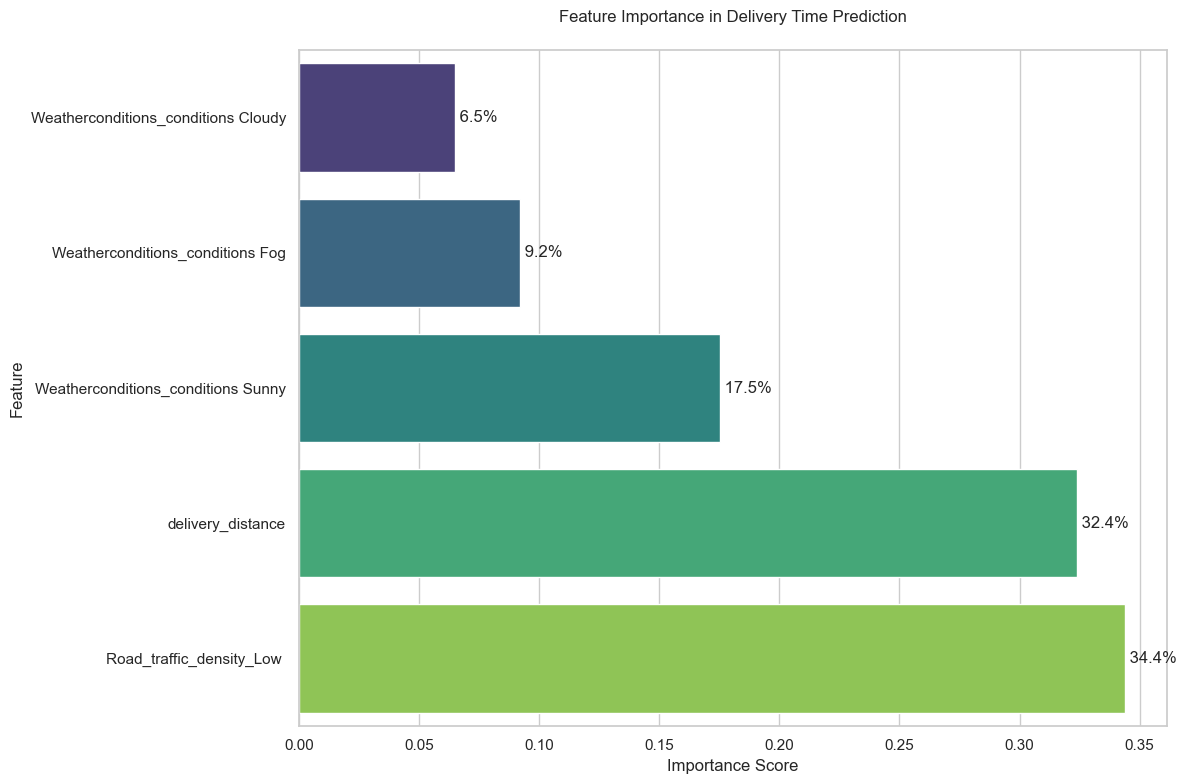

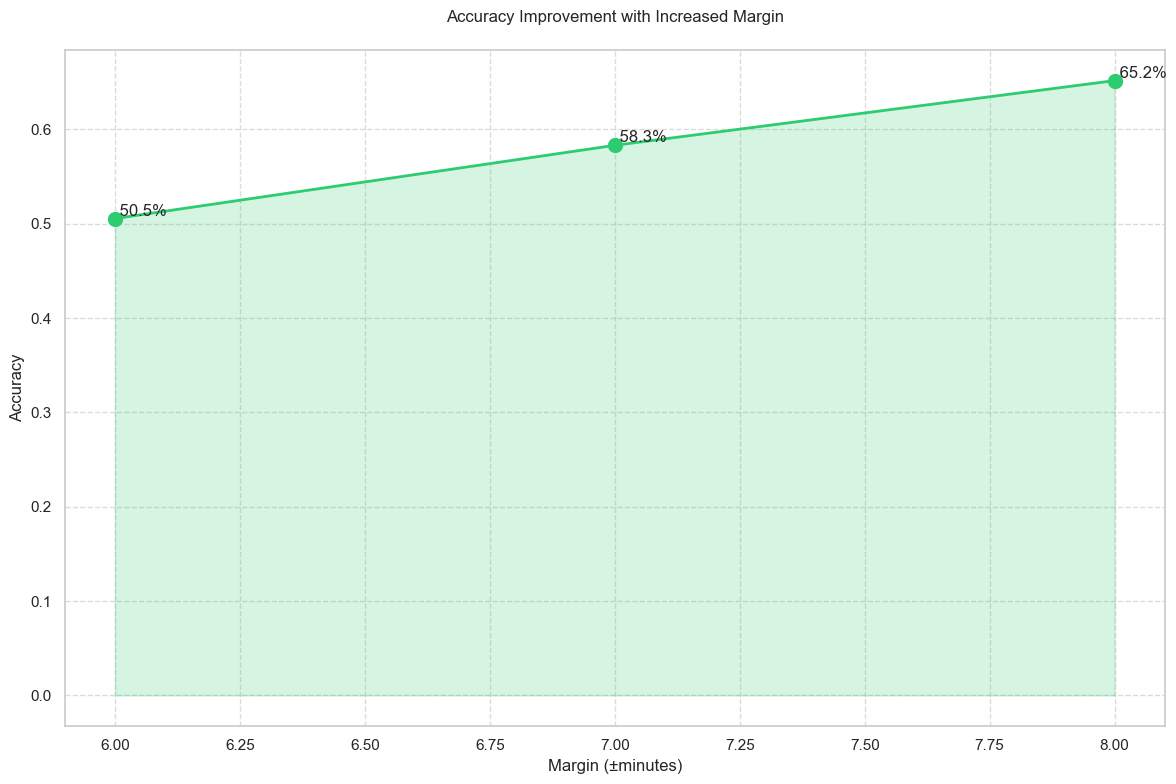

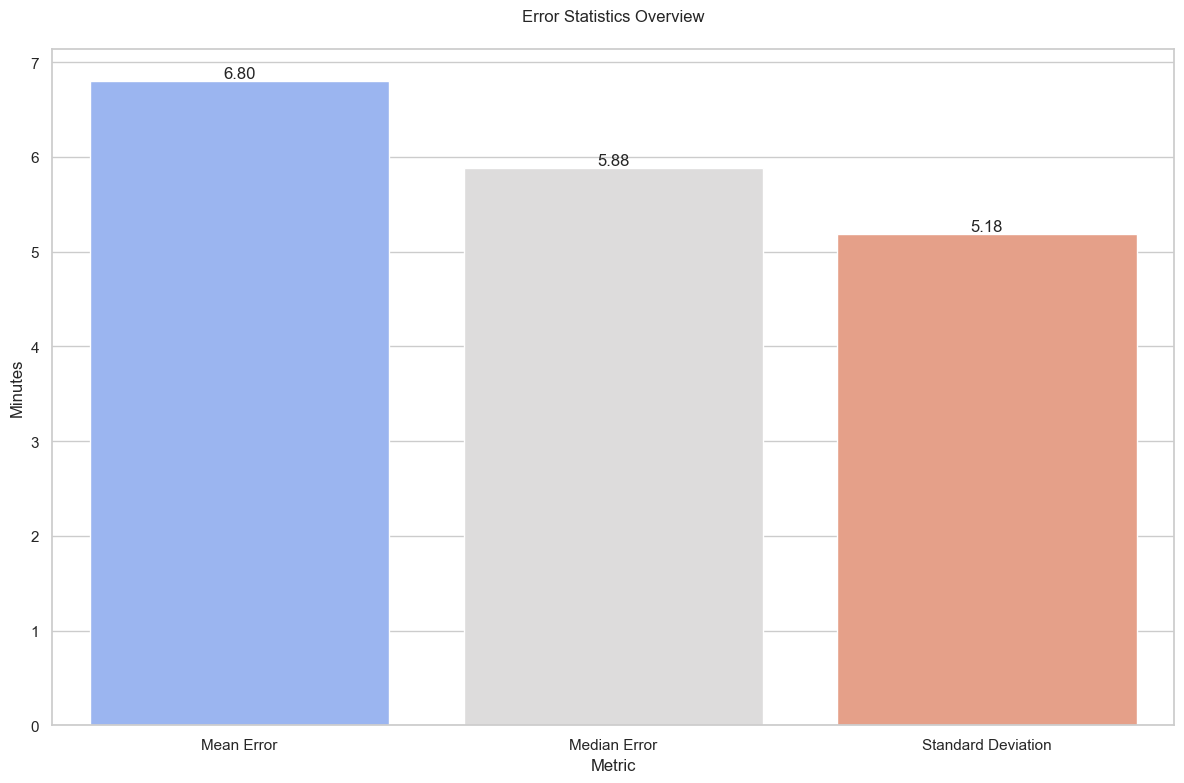

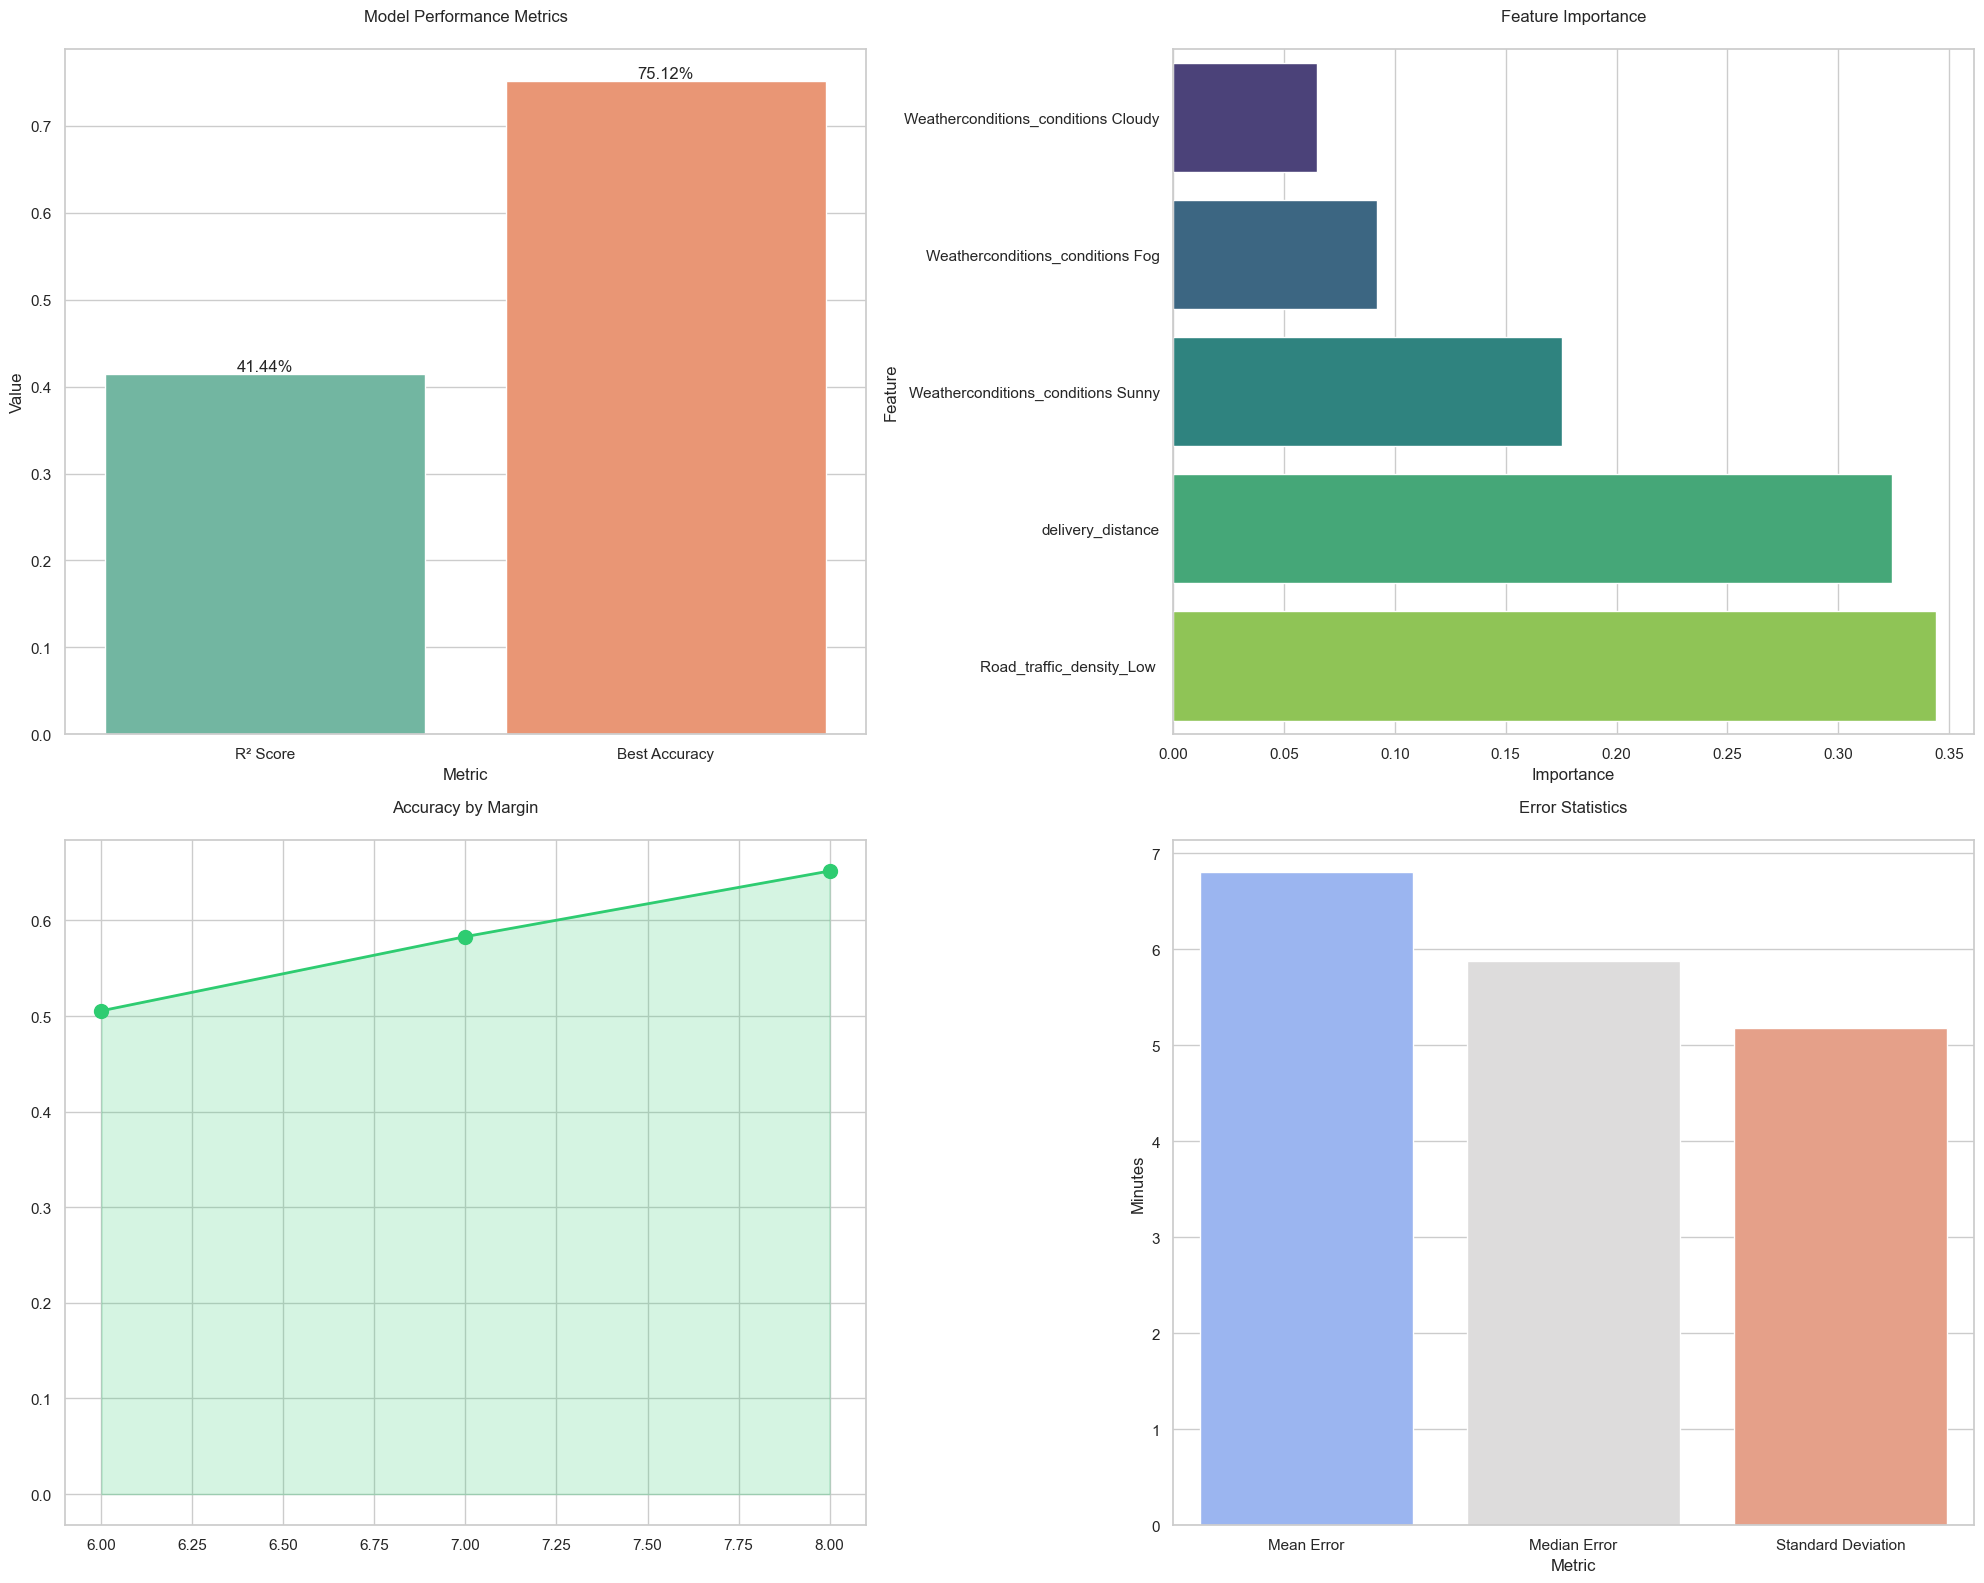

All visualizations and summary report have been generated!


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set basic style parameters
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.grid'] = True
sns.set_theme(style="whitegrid")

# Your results
best_r2 = 0.4144
best_accuracy = 0.7512
best_margin = 8
best_features = ['Weatherconditions_conditions Fog', 
                'Weatherconditions_conditions Cloudy', 
                'delivery_distance', 
                'Weatherconditions_conditions Sunny', 
                'Road_traffic_density_Low ']

feature_importance = {
    'Weatherconditions_conditions Fog': 0.0918,
    'Weatherconditions_conditions Cloudy': 0.0647,
    'delivery_distance': 0.3241,
    'Weatherconditions_conditions Sunny': 0.1754,
    'Road_traffic_density_Low ': 0.3440
}

accuracies = {
    6: 0.5055,
    7: 0.5831,
    8: 0.6517
}

error_stats = {
    'mean': 6.80,
    'median': 5.88,
    'std': 5.18
}

# 1. Feature Importance Visualization
plt.figure()
importance_df = pd.DataFrame(list(feature_importance.items()), 
                           columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=True)

sns.barplot(data=importance_df, y='Feature', x='Importance', palette='viridis')
plt.title('Feature Importance in Delivery Time Prediction', pad=20)
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# Add percentage labels
for i, v in enumerate(importance_df['Importance']):
    plt.text(v, i, f' {v:.1%}', va='center')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Accuracy Progress by Margin
plt.figure()
margins = list(accuracies.keys())
acc_values = list(accuracies.values())

plt.plot(margins, acc_values, marker='o', linewidth=2, markersize=10, color='#2ecc71')
plt.fill_between(margins, acc_values, alpha=0.2, color='#2ecc71')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Accuracy Improvement with Increased Margin', pad=20)
plt.xlabel('Margin (±minutes)')
plt.ylabel('Accuracy')

# Add value labels
for i, v in enumerate(acc_values):
    plt.text(margins[i], v, f' {v:.1%}', va='bottom')

plt.tight_layout()
plt.savefig('accuracy_by_margin.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Error Statistics Visualization
plt.figure()
error_metrics = pd.DataFrame({
    'Metric': ['Mean Error', 'Median Error', 'Standard Deviation'],
    'Minutes': [error_stats['mean'], error_stats['median'], error_stats['std']]
})

sns.barplot(data=error_metrics, x='Metric', y='Minutes', palette='coolwarm')
plt.title('Error Statistics Overview', pad=20)
plt.ylabel('Minutes')

# Add value labels
for i, v in enumerate(error_metrics['Minutes']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('error_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Interactive Sunburst of Feature Importance
fig = go.Figure(go.Sunburst(
    labels=['Delivery Time'] + list(feature_importance.keys()),
    parents=[''] + ['Delivery Time']*len(feature_importance),
    values=[1] + list(feature_importance.values()),
    branchvalues='total',
))
fig.update_layout(
    title='Feature Importance Hierarchy',
    width=800,
    height=800
)
fig.write_html('feature_importance_sunburst.html')

# 5. Summary Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# R² and Accuracy
metrics = pd.DataFrame({
    'Metric': ['R² Score', 'Best Accuracy'],
    'Value': [best_r2, best_accuracy]
})
sns.barplot(data=metrics, x='Metric', y='Value', ax=ax1, palette='Set2')
ax1.set_title('Model Performance Metrics', pad=20)
for i, v in enumerate(metrics['Value']):
    ax1.text(i, v, f'{v:.2%}', ha='center', va='bottom')

# Feature Importance
sns.barplot(data=importance_df, y='Feature', x='Importance', ax=ax2, palette='viridis')
ax2.set_title('Feature Importance', pad=20)

# Accuracy Progress
ax3.plot(margins, acc_values, marker='o', linewidth=2, markersize=10, color='#2ecc71')
ax3.fill_between(margins, acc_values, alpha=0.2, color='#2ecc71')
ax3.set_title('Accuracy by Margin', pad=20)

# Error Statistics
sns.barplot(data=error_metrics, x='Metric', y='Minutes', ax=ax4, palette='coolwarm')
ax4.set_title('Error Statistics', pad=20)

plt.tight_layout()
plt.savefig('summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a summary report
summary = f"""
# Delivery Time Prediction Model Analysis

## Key Performance Metrics
- R² Score: {best_r2:.2%}
- Best Accuracy: {best_accuracy:.2%} (at ±{best_margin} minutes)

## Error Statistics
- Mean Error: {error_stats['mean']:.2f} minutes
- Median Error: {error_stats['median']:.2f} minutes
- Standard Deviation: {error_stats['std']:.2f} minutes

## Accuracy Progress
{pd.DataFrame(accuracies.items(), columns=['Margin', 'Accuracy']).to_string(index=False)}

## Feature Importance Ranking
{importance_df.to_string(index=False)}

## Generated Visualizations
1. feature_importance.png - Detailed feature importance bar chart
2. accuracy_by_margin.png - Accuracy improvement with increased margin
3. error_statistics.png - Overview of error metrics
4. feature_importance_sunburst.html - Interactive feature importance visualization
5. summary_dashboard.png - Complete model performance dashboard
"""

# Save summary report
with open('model_analysis_summary.md', 'w') as f:
    f.write(summary)

print("All visualizations and summary report have been generated!")

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a directory for saving the plots if it doesn't exist
if not os.path.exists('presentation_plots'):
    os.makedirs('presentation_plots')

# 1. Weather Impact Chart
plt.figure(figsize=(10, 6))
weather_impact = pd.DataFrame({
    'Weather Condition': ['Foggy', 'Rainy', 'Stormy', 'Sunny', 'Windy'],
    'Delay Impact (%)': [15, 10, 12, 0, 5]
})

sns.barplot(x='Weather Condition', y='Delay Impact (%)', 
            data=weather_impact, 
            palette='coolwarm')
plt.title('Weather Impact on Delivery Times', pad=20)
plt.ylabel('Additional Delivery Time (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Save weather plot
plt.savefig('presentation_plots/weather_impact.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.close()

# 2. Traffic Pattern Throughout Day
plt.figure(figsize=(12, 6))
hours = list(range(0, 24))
traffic_density = [
    30, 20, 15, 10, 15, 35,  # 0-5 AM
    50, 75, 80, 65, 55, 60,  # 6-11 AM
    70, 65, 45, 40, 50, 75,  # 12-5 PM
    90, 85, 70, 55, 45, 35   # 6-11 PM
]

plt.plot(hours, traffic_density, marker='o', linewidth=2, markersize=8)
plt.fill_between(hours, traffic_density, alpha=0.2)
plt.title('Traffic Patterns Throughout the Day', pad=20)
plt.xlabel('Hour of Day')
plt.ylabel('Traffic Density (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(hours)
plt.ylim(0, 100)

# Add peak and off-peak annotations
plt.annotate('Peak Hours', xy=(18, 90), xytext=(18, 95),
            ha='center', va='bottom')
plt.annotate('Lowest Traffic', xy=(3, 10), xytext=(3, 15),
            ha='center', va='bottom')
# Save traffic plot
plt.savefig('presentation_plots/traffic_pattern.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.close()

# 3. Factor Importance Bar Chart
plt.figure(figsize=(10, 6))
factors = pd.DataFrame({
    'Factor': ['Distance', 'Traffic', 'Weather', 'Time of Day', 'Vehicle Type'],
    'Impact (%)': [45, 25, 15, 10, 5]
})

sns.barplot(x='Impact (%)', y='Factor', 
            data=factors, 
            palette='viridis')
plt.title('Factors Affecting Delivery Time', pad=20)
plt.xlabel('Impact on Delivery Time (%)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentage labels on bars
for i, v in enumerate(factors['Impact (%)']):
    plt.text(v + 0.5, i, f'{v}%', va='center')

plt.tight_layout()
# Save factors plot
plt.savefig('presentation_plots/factor_importance.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.close()

print("All plots have been saved in the 'presentation_plots' directory!")

All plots have been saved in the 'presentation_plots' directory!


In [3]:
# Import necessary library
import joblib

# Save the trained model
joblib.dump(rf_model, 'random_forest_delivery.pkl')

# Save the scaler too (you'll need this for new predictions)
joblib.dump(scaler, 'scaler_delivery.pkl')

# Optional: Save feature names for reference
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names_delivery.pkl')

print("Model and supporting files saved successfully!")

NameError: name 'rf_model' is not defined